# PDE Modelling 

## Objectives 
* Make a model that describes cell growth and signalling at the scale of colonies 

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. Environmental AHL (considered equal to intracellular concentration)
    1. Synthase / sfCFP
    1. Repressor / mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Transcriptional activation
        * Basal protein expression -> scaled by repression? probably
        * Activation by internal AHL 
        * Use Hill function $$H(A(t), n, k) = \frac{A(t)^n}{k^n + A(t)^n}$$
        * Activation term, with basal expression and expression rate x
        $$X(A(t), n, k, b, x) = x\frac{A(t)^2}{k^n + A(t)^n} + b$$
    1. Transcriptional repression
        * Assume activation is AND-like, meaning that repression trumps activation
        * Use 'repression' Hill function $$H_n(R(t), n, k) = \frac{k^n}{k^n + R(t)^n}$$
        * Rather than considering protein concentrations within cells, calculate protein concentrations as produced by the bulk of cells. Expression is therefore proportional to cell density.
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xa : Synthesis rate of AHL. 
        * xs : Expression rate of protein. 
        * ha : Hill coefficient of AHL-inducible expression.
        * ka : Half-point of AHL-inducible expression. 
        * pa : Degradation rate of AHL.
        * leak : Leaky expression rate of protein. 
        


In [42]:
# imports
from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi

import matplotlib as mpl
import seaborn as sns
import itertools

import matplotlib.pyplot as plt 
import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import skimage.morphology
import numba
import gc

from multiprocessing import Pool, Process

%load_ext line_profiler

import bokeh
from bokeh.plotting import figure, output_file, save
from bokeh.io import output_notebook, show
from bokeh import palettes, transform
from bokeh.models import LogColorMapper, LogTicker, ColorBar, LinearColorMapper, Ticker
output_notebook()

from IPython.display import HTML

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('paper', rc=rc)

%matplotlib inline

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Loading BokehJS ...

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

In [40]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [43]:
## Universal constants

scale = 12 # The number of simulation positions per 2.25mm (384 well plate inter-well distance)
scale_s = 4 # droplet size from echo
n_w = 10 * scale
n_h = 5 * scale
tmax = 20*60 # min
nutrient_max = 100
rtol = 1e-3 # Relative tolerance, a integration parmater.
col_thresh = 0.01

# Set initial conditions(species)
species = 13
cl_i, cc_i, cr_i, n_i, al_i, ac_i, ar_i, sl_i, sc_i, sr_i, rl_i, rc_i, rr_i = np.arange(species)
cell_inds = [cl_i, cc_i, cr_i]
ahl_inds = [al_i, ac_i, ar_i]
syn_inds = [sl_i, sc_i, sr_i]
rep_inds = [rl_i, rc_i, rr_i]

# Params :    ,           dx               Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
p0 = np.array([np.power((scale/4.5),2),   0,    8e-3,  8e-3, 15,  3e-2,  1, 3e-2, 8e-2, 5e2, 2e2, 
#xr,   hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   od0
1e3, 3.2, 100, 2.3, 55, 3.2, 2.7e3, 16e-3, 3e3, 0.01], dtype=np.float32)

#p0 = np.array([np.power((scale/4.5),2),   0,    8e-3,  8e-3, 15,  3e-2,  1, 3e-2, 8e-2, 5e2, 2e2, 
#xr,   hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   od0
#1e3, 3.2, 100, 2.3, 55, 3.2, 2.7e3, 16e-3, 3e4, 0.1], dtype=np.float32)

# Set absolute tolerance
atol = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7

for cell_i in cell_inds : 
    atol[cell_i,:,:] = 1e-5*np.ones((n_h, n_w), dtype=np.float32)

atol[n_i,:,:]  = 1e-2*np.ones((n_h, n_w), dtype=np.float32)
    
for ahl_i in ahl_inds:
    atol[ahl_i,:,:]  = 1e-3*np.ones((n_h, n_w), dtype=np.float32)
    
for syn_i in syn_inds:
    atol[syn_i,:,:]  = 1e-5*np.ones((n_h, n_w), dtype=np.float32)
        
for rep_i in rep_inds:
    atol[rep_i,:,:]  = 1e-4*np.ones((n_h, n_w), dtype=np.float32)

atol.shape = species*n_h*n_w

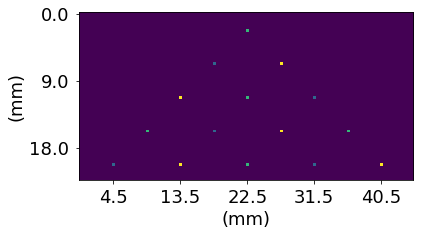

In [44]:
def disk(A, center, radius):
    h, w = A.shape
    ind_mat = np.zeros((h, w, 2))
    cx, cy = center
    for i in range(h):
        ind_mat[i,:,0] = np.power(np.arange(w) - cx, 2)
    
    for i in range(w):
        ind_mat[:,i,1] = np.power(np.arange(h) - cy, 2)
    
    outmat = (ind_mat[:,:,0] + ind_mat[:,:,1]) < radius**2
    return outmat

def prep_spot_positions():
    cell_spots_list = []
    skip = (scale)
    def spot_indices(skip, mod_val):
        return np.array([(i,j) for i in np.arange(1*n_w//10,(9*n_w//10)+1,skip) 
                                 for j in np.arange(1*n_h//10,(9*n_h//10)+1,skip) 
                                    if np.mod((i-(n_w//10))//skip,3)==mod_val 
                                         and np.abs(j-(1*n_h//10)) >= np.abs(i-(n_w//2))
                                         and np.mod((i-(n_w//10))//skip,2) == np.mod((j-(n_h//10))//skip,2)])
    
    cl_spots = spot_indices(skip, 0)
    cell_spots_list.append(cl_spots)
    cc_spots = spot_indices(skip, 1)
    cell_spots_list.append(cc_spots)
    cr_spots = spot_indices(skip, 2)
    cell_spots_list.append(cr_spots)

    ahl_spots_list = [[(n_w//2, 1*n_h//10)],[],[]]
    return cell_spots_list, ahl_spots_list

def prep_initial_condition(A):
    dx, Dc,  rc, rp,    Kn,  Dn,   kn, Da, xa, xs, xS, xr, hS, kS, hR, kR, hC, kC, pa, ahl0, od = p0
    tmp_arr = np.zeros((n_h, n_w), dtype=np.float32)
    for cell_i, cell_spots in zip(cell_inds, cell_spots_list):
        for center in cell_spots:
            A[cell_i,:,:] += disk(tmp_arr, np.array(center), scale/6)*od
        arr_max = np.max([A[cell_i,:,:].max(),1])
        A[cell_i,:,:] = skimage.filters.gaussian(A[cell_i,:,:]/arr_max, sigma=0.7)*arr_max
    
    for ahl_i, ahl_spots in zip(ahl_inds, ahl_spots_list):
        for center in ahl_spots:
            A[ahl_i,:,:] += disk(tmp_arr, np.array(center), scale/6)*ahl0
        arr_max = np.max([A[ahl_i,:,:].max(),1])
        A[ahl_i,:,:] = skimage.filters.gaussian(A[ahl_i,:,:]/arr_max, sigma=0.7)*arr_max
    return A

# Set initial conditions
cell_spots_list, ahl_spots_list = prep_spot_positions()
initial_array = np.zeros((species, n_h, n_w), dtype=np.float32, order='C')# + 1e-7
initial_array[n_i,:,:] = nutrient_max*np.ones((n_h, n_w), dtype=np.float32)
initial_array = prep_initial_condition(initial_array)

# Look at initial arrangement
im_dep = np.zeros((n_h, n_w))
for cell_i in cell_inds:
    im_dep += (cell_i+1)*(initial_array[cell_i,:,:] > 0.008)
plt.imshow(im_dep)
plt.xticks(scale*np.arange(1,10,2), ["{:.1f}".format(xx) for xx in np.arange(1,10,2)*4.5])
plt.xlabel('(mm)')
plt.yticks(scale*np.arange(0,5,2), ["{:.1f}".format(xx) for xx in np.arange(0,5,2)*4.5])
plt.ylabel('(mm)')
plt.title('')

In [49]:
@numba.jit(nopython=True, cache=True)
def hill(a, n, k):
    h_ma = 1 - (1 / (1 + (a/k)**n))
    return h_ma

@numba.jit(nopython=True, cache=True)
def hillN(a, n, k):
    return 1 / (1 + (a/k)**n)

@numba.jit(nopython=True, cache=True)
def calc_diffusion(A, D):
    # Middle
    D[:,1:-1,1:-1] = A[:,1:-1, 2:] + A[:,1:-1, :-2] + A[:,:-2, 1:-1] + A[:,2:, 1:-1] - 4*A[:,1:-1, 1:-1]
    # Edges
    D[:,0,1:-1] = A[:,0, 2:] + A[:,0, :-2] + A[:,1, 1:-1] - 3*A[:,0, 1:-1]
    D[:,-1,1:-1] = A[:,-1, 2:] + A[:,-1, :-2] + A[:,-2, 1:-1] - 3*A[:,-1, 1:-1]
    D[:,1:-1,0] = A[:,2:,0] + A[:,:-2,0] + A[:,1:-1,1] - 3*A[:,1:-1,0]
    D[:,1:-1,-1] = A[:,2:,-1] + A[:,:-2,-1] + A[:,1:-1,-2] - 3*A[:,1:-1,-1]
    # Corners
    D[:,0,0] = A[:,0,1] + A[:,1,0] - 2*A[:,0,0]
    D[:,-1,0] = A[:,-1,1] + A[:,-2,0] - 2*A[:,-1,0]
    D[:,0,-1] = A[:,0,-2] + A[:,1,-1] - 2*A[:,0,-1]
    D[:,-1,-1] = A[:,-1,-2] + A[:,-2,-1] - 2*A[:,-1,-1]

@numba.jit(cache=True)
def calc_f(t, y, d_y, diff_terms, nut_avail):
    dx, Dc,  rc, rp,    Kn,  Dn,   kn, Da, xa, xs, xS, xr, hS, kS, hR, kR, hC, kC, pa, leak, od = p0
    
    y_sub = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')
    y_sub[:] = y.reshape((species, n_h, n_w))
    y = y_sub
    
    calc_diffusion(y, diff_terms)
    
    # Growth term
    nut_avail[:] = hill(y[n_i,:,:], 2.5, Kn)
    
    # Cell growth and diffusion
    for ind in cell_inds:
        d_y[ind,:,:] = rc * nut_avail * y[ind,:,:]
    
    # Nutrient consumption
    d_y[n_i,:,:] = (dx)*Dn*diff_terms[n_i,:,:] - kn * nut_avail * y[cell_inds,:,:].sum(axis=0)
    
    # AHL production
    for cell_i, ahl_i, syn_i in zip(cell_inds, ahl_inds, syn_inds):
        d_y[ahl_i,:,:] = (dx)*Da*diff_terms[ahl_i,:,:] + xa * y[syn_i,:,:]*y[cell_i,:,:] - pa * y[ahl_i,:,:]
    
    # Synthase production
    # Left synthase 
    d_y[sl_i,:,:] = np.greater(y[cl_i,:,:],col_thresh) * nut_avail * (
                        xs * hill(y[ac_i,:,:], hS, kS) * hillN(y[rc_i,:,:], hC, kC) + 
                        xs * hill(y[ar_i,:,:], hS, kS) * hillN(y[rr_i,:,:], hC, kC) + 
                        rc * y[sl_i,:,:]) - rp * y[sl_i,:,:]
    
    # center synthase 
    d_y[sc_i,:,:] = np.greater(y[cc_i,:,:],col_thresh) * nut_avail * (
                        xs * hill(y[al_i,:,:], hS, kS) * hillN(y[rl_i,:,:], hC, kC) + 
                        xs * hill(y[ar_i,:,:], hS, kS) * hillN(y[rr_i,:,:], hC, kC) + 
                        rc * y[sc_i,:,:]) - rp * y[sc_i,:,:]
    
    # right synthase 
    d_y[sr_i,:,:] = np.greater(y[cr_i,:,:],col_thresh) * nut_avail * (
                        xs * hill(y[al_i,:,:], hS, kS) * hillN(y[rl_i,:,:], hC, kC) + 
                        xs * hill(y[ac_i,:,:], hS, kS) * hillN(y[rc_i,:,:], hC, kC) + 
                        rc * y[sr_i,:,:]) - rp * y[sr_i,:,:]

    # Repressor production
    # left repressor
    d_y[rl_i,:,:] = nut_avail *(
            xr * hill(y[ac_i,:,:], hR, kR) * np.greater(y[cr_i,:,:],col_thresh) + 
            xr * hill(y[ar_i,:,:], hR, kR) * np.greater(y[cc_i,:,:],col_thresh) -
            rc * y[rl_i,:,:]
        ) - rp * y[rl_i,:,:]
    
    # center repressor
    d_y[rc_i,:,:] = nut_avail *(
            xr * hill(y[al_i,:,:], hR, kR) * np.greater(y[cr_i,:,:],col_thresh) + 
            xr * hill(y[ar_i,:,:], hR, kR) * np.greater(y[cl_i,:,:],col_thresh) -
            rc * y[rc_i,:,:]
        ) - rp * y[rc_i,:,:]
    
    # right repressor
    d_y[rr_i,:,:] = nut_avail *(
            xr * hill(y[ac_i,:,:], hR, kR) * np.greater(y[cl_i,:,:],col_thresh) + 
            xr * hill(y[al_i,:,:], hR, kR) * np.greater(y[cc_i,:,:],col_thresh) -
            rc * y[rr_i,:,:]
        ) - rp * y[rr_i,:,:]
    
    return d_y.flatten()

def sim():
    initial_array = np.zeros((species, n_h, n_w), dtype=np.float32, order='C')# + 1e-7
    initial_array[n_i,:,:] = nutrient_max*np.ones((n_h, n_w), dtype=np.float32)
    initial_array = prep_initial_condition(initial_array)
    
    args=(np.zeros(initial_array.shape, dtype=np.float32,order='C'), 
          np.zeros(initial_array.shape, dtype=np.float32,order='C'), 
          np.zeros(initial_array.shape[1:], dtype=np.float32,order='C'), 
          p0)
    initial_array.resize((n_h*n_w*species,),refcheck=False)
    atol.resize((n_h*n_w*species,),refcheck=False)
    f_lambda = lambda t, y : calc_f(t, y, *args)
    out = itg.solve_ivp(f_lambda, [0, tmax], initial_array, vectorized=True, method='RK23', 
                        atol=atol, rtol=rtol)
    exp_t = out.t
    exp_y = out.y.T
    exp_y.shape = (len(exp_t), species, n_h, n_w)
    return exp_y, exp_t

In [46]:
img, tvec = sim()

/anaconda/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:140: RuntimeWarning: invalid value encountered in maximum
  scale = atol + np.maximum(np.abs(y), np.abs(y_new)) * rtol


In [48]:
def write_movie(im_arr, t_vec, skip=1, n_frames=200, score=None, indx=None):
    plt.close('all')
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = np.arange(0,w+1,scale)
    xticklabels = ["{:0.1f}".format(x) for x in xticks*4.5/scale ]
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([n_h, n_w])
    fig, axs = plt.subplots(3,2, figsize=(12.5,10))
    fig.suptitle("Indx:{} Score:{}".format(indx, score), fontsize=18)
    im_list = [0,0,0,0,0,0,0]
    
    # Plot cell densities
    ax = axs[0,0]
    indxs = cell_inds
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[0,1]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[1,0]
    indxs = syn_inds
    v_arr = im_arr[frames//2,indxs,:,:].sum(axis=0)
    vmax = v_arr.max()
    vmin = 0
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[2] = im
    
    # Plot AHL densities
    ax = axs[1,1]
    indxs = ahl_inds
    v_arr = im_arr[-1,indxs,:,:].sum(axis=0)
    vmax = 200#v_arr.max()
    vmin = 0#v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('AHLs')
    im_list[3] = im
    
    # Plot colony masks
    ax = axs[2,0]
    indxs = cell_inds
    vmax = 1
    vmin = 0
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.linspace(tvec[0], tvec[-1], len(xticks))//60)
    ax.set_yticks([])
    ax.set_title('time (hours)')
    im_list[4] = im
    
    # Plot represors masks
    ax = axs[2,1]
    indxs = rep_inds
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = 0
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('repressors')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0,0]
        indxs = cell_inds
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[0,1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[1,0]
        indxs = syn_inds
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[2].set_array(frame_arr)

        # Plot ahl densities
        ax = axs[1,1]
        indxs = ahl_inds
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot colony masks
        ax = axs[2,0]
        indxs = cell_inds
        frame_arr = np.zeros((h,w))
        time_i = np.int(w*t_point/len(f_inds))
        frame_arr[:,time_i] = 1
        mask, labls = skimage.measure.label(frame_arr,return_num=True, connectivity=1) 
        im_list[4].set_array(mask)
        
        # Plot repressors 
        ax = axs[2,1]
        indxs = rep_inds
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)
        
        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())


In [50]:
indx_str = 2331
anim = write_movie(img, tvec, skip=4, score=None, indx=indx_str)
HTML(anim.to_html5_video())

## Code below this line has not been reorganized

In [5]:
def score_movie(im_movie):
    final_syn = im_movie[:,syn_inds,:,:].max(axis=0).sum(axis=0)
    if np.all(final_syn == final_syn[0,0]):
        return 0
    thresh = skimage.filters.threshold_otsu(final_syn)
    thresh_syn = final_syn > thresh
    arr = np.zeros((species, n_h, n_w))
    dest_wells, ahl_centers = prep_spot_positions(n_h, n_w)
    dims = np.array([species, n_h, n_w])
    arr = prep_initial_condition(dest_wells, ahl_centers, dims, p0, arr)
    mask = arr[cell_inds,:,:].sum(axis=0) > 0
    im_label = skimage.morphology.label(mask)
    im_ac_mask = np.zeros(im_label.shape)
    im_ac_pnlt = np.zeros(im_label.shape)
    for i in np.arange(1,np.max(im_label)+1):
        if i in [1, 2, 4, 5, 9, 10, 12, 14, 16, 17, 25]:
            im_ac_mask += im_label == i
        else:
            im_ac_pnlt += im_label == i
    score = np.sum(thresh_syn * im_ac_mask) - np.sum(thresh_syn * im_ac_pnlt)
    return score

noxs_flag = False
# Change parameter values above. The function definitions inherit the parameter values defined here.
dx, Dc,  rc, rp,    Kn,  Dn,   kn, Da, xa, xs, xS, xr, hS, kS, hR, kR, hC, kC, pa, leak, od0 = p0
cols = ('score','scale','n_h','n_w','dx','Dc','rc','rp','Kn','Dn','kn','Da','xa','xs','xS','xr','hS','kS',
        'hR','kR','hC','kC','pa','leak','od0')
def_parms = pd.Series(p0, cols[4:])
parm_df = pd.DataFrame(columns=cols)

p0_list = [0,scale,n_h,n_w] + list(p0)
# scale,n_h,n_w = [int(x) for x in (scale,n_h,n_w)]
out_list = []
n_powers = 5
# var_list = ["kC", "xS", "xs", 'xa', 'xr', 'od0', 'pa', 'rc', "kn"]
# pow_list = [5,    5,  5,   5,   5,    2,    5,   2, 2]
var_list = ["xs", 'xr', 'od0', 'kC', 'leak']#, "xs"]#, 'xa', 'xr', 'pa', 'rp']
n_var = len(var_list)
pow_list = [5, 5, 2, 5, 5]#[5,     5,   5]#, 5, 5]#,  10]#,   10,    10,  10,   10]
pow_series = pd.Series(np.array(pow_list), index=var_list)
# var_list_noxs = ["kC", 'xa', 'xr', 'od0']
var_list_noxs = ['kC', 'xS', 'xa', 'xr', 'od0', 'pa', 'rc', 'kn']
var_tuples = [(v1, v2) for v1 in var_list for v2 in var_list]
var_tuples_noxs = [(v1, v2) for v1 in var_list_noxs for v2 in var_list_noxs]
range_var = np.power(10.0,np.linspace(-2,2,n_powers))
range_fn = lambda x : np.power(x, np.linspace(-2,2,n_powers))
range_dict = dict(zip(var_list, [range_fn(xx) for xx in pow_list]))

prod_input = [ range_dict[xx]*def_parms.loc[xx] for xx in var_list]
parm_tuples = itertools.product(*prod_input)
for parm_tuple in parm_tuples:
    parm_row = pd.DataFrame(np.array([p0_list]),columns=cols)
    parm_row.loc[:, var_list] = np.array(parm_tuple)
    parm_df = parm_df.append(parm_row)

# for var_tup in var_tuples:
#     v1, v2 = var_tup
#     param_row = pd.DataFrame(np.array([p0_list]),columns=cols)
#     range_var_1 = range_fn(pow_series[v1])
#     range_var_2 = range_fn(pow_series[v2])
#     for r1 in range_var_1:
#         for r2 in range_var_2:
#             param_row.loc[0,v1] = r1 * def_parms[v1]
#             param_row.loc[0,v2] = r2 * def_parms[v2]
#             parm_df = parm_df.append(param_row.copy())

# for var_tup in var_tuples_noxs:
#     v1, v2 = var_tup
#     param_row = pd.DataFrame(np.array([p0_list]),columns=cols)
#     range_var_1 = range_fn(pow_series[v1])
#     range_var_2 = range_fn(pow_series[v2])
#     for r1 in range_var_1:
#         for r2 in range_var_2:
#             param_row.loc[0,v1] = r1 * def_parms[v1]
#             param_row.loc[0,v2] = r2 * def_parms[v2]
#             parm_df = parm_df.append(param_row.copy())

parm_df.index = np.arange(parm_df.shape[0])

def par_worker(df_sub):
    csv_fn = "pool_params/params_part_{}.csv"
    df_fn = "pool_params/df_part_{}.csv"
    img_fn = "pool_params/imgs_part_{}.npy"
    tvec_fn = "pool_params/tvec_part_{}.npy"
    for i in df_sub.index:
        score,scale,n_h,n_w,dx,Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,od0 = df_sub.loc[i,:]
        scale,n_h,n_w = [int(x) for x in (scale,n_h,n_w)]
        p0 = np.array([dx,Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,od0])
        img, tvec = sim(n_h, n_w, p0)
        df_sub.loc[i,"score"] = score_movie(img)
        df_sub.loc[i,:].to_csv(csv_fn.format(i), header=True)
    df_sub.to_csv(df_fn.format(df_sub.index.values[0]))
#         np.save(img_fn.format(i), img)
#         np.save(tvec_fn.format(i), tvec)
        
def par_worker_noxs(df_sub):
    csv_fn = "pool_params/params_part_noxs_{}.csv"
    img_fn = "pool_params/imgs_part_noxs_{}.npy"
    tvec_fn = "pool_params/tvec_part_noxs_{}.npy"
    for i in df_sub.index:
        scale,n_h,n_w,dx,Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,od0 = df_sub.loc[i,:]
        scale,n_h,n_w = [int(x) for x in (scale,n_h,n_w)]
        p0 = np.array([dx,Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,od0])
        img, tvec = sim(n_h, n_w, p0)
        df_sub.loc[i,"score"] = score_movie(img)
        df_sub.loc[i,:].to_csv(csv_fn.format(i))
#         np.save(img_fn.format(i), img)
#         np.save(tvec_fn.format(i), tvec)

par_list = ["c0", "c1", "c2"]
calc_features = ['reach', 'pulse', 'mean_v', 'amp', 'width', 'first'] 
pulse_features = [ "{}_{}".format(yy, xx) 
                  for xx in par_list + calc_features
                  for yy in ["sfcfp", "mscarlet"]]
score_cols = var_list + ['score']


print("parm_df shape:", parm_df.shape)

parm_df shape: (3125, 25)


In [ ]:
        
jobs = []
for i in np.arange(4):
    p = Process(target=par_worker, args=(parm_df.loc[i::4,:].copy(),))
    jobs.append(p)
    p.start()

for job in jobs:
    job.join()
    out_list.append(sim(n_h, n_w, p0))

# anim = write_movie(out, t_vec, 8) #, out_names[i])
# HTML(anim.to_html5_video())

fit_df = pd.DataFrame(np.zeros((len(out_list), len(cols))), columns=cols, dtype=np.float)

print("done with this cell")

Starting
(93600,)
(93600,)
Starting
(93600,)
(93600,)
Starting
(93600,)
(93600,)
Starting
(93600,)
(93600,)


# Take a look at one frame
out.resize((t_points,species,n_h,n_w))

print(out.shape)

plt.close('all')
fig, axs = plt.subplots(1,species, figsize=(19,5))
for i in np.arange(species):
    ax = axs[i]
    img = ax.imshow(out[-1,i,:,:], interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = fig.colorbar(mappable=img, ax=ax)
plt.show()

In [7]:
score_df.sort_values('score', ascending=False)

NameError: name 'score_df' is not defined

t_i = np.arange(im_t)[colony_mean[:,0].max() == colony_mean[:,0]]
masks, ls = skimage.measure.label(
    np.logical_xor(im_arr[t_i, 0, :, :] > 0.12, 
                   im_arr[t_i, 1, :, :] > 0.12), 
    connectivity=1, 
    return_num=True)
labels_vec[t_i] = labels
plt.imshow(masks[0])
print(ls)

In [16]:
# csv_list = [xx for xx in os.listdir('pool_params/') if xx[-4:] == '.csv' and 'params_part' in xx]
# df_list = [pd.read_csv('pool_params/'+xx).T.iloc[1:,:] for xx in csv_list]
# for df in df_list:
#     df.columns = cols
# score_df = pd.DataFrame(columns=cols)
# score_df = score_df.append(df_list)
# df_list = [pd.DataFrame(dict(zip(tmp.values.T[0,:],tmp.values.T[1,:])), index=[0]) for tmp in df_list]
# df = pd.concat(df_list, ignore_index=True)
# plt.plot(df.score.values)
# score_df.to_csv('pool_params/score_df.csv')

In [20]:
# fig, axs = plt.subplots(len(out_list),2 + len(var_list),figsize=(10,30))

fit_df = pd.DataFrame(np.zeros((len(out_list), len(cols))), columns=cols, dtype=np.float)

if noxs_flag:
    csv_fn = "pool_params/params_part_noxs_{}.csv"
    img_fn = "pool_params/imgs_part_noxs_{}.npy"
    tvec_fn = "pool_params/tvec_part_noxs_{}.npy"
    png_fn = "pool_params/png_part_noxs_{}.png"
else:
    csv_fn = "pool_params/params_part_{}.csv"
    img_fn = "pool_params/imgs_part_{}.npy"
    tvec_fn = "pool_params/tvec_part_{}.npy"
    png_fn = "pool_params/png_part_{}.png"
    
def f_fun(p, t):
    c0,c1,c2 = p
    return c0 + c1 * (t)**c2

def f_res(p, t, fit_x):
    c0,c1,c2 = p
    if c1 < 0:
        return np.inf
    if c2 < 0:
        return np.inf
    res = fit_x - f_fun(p, t)
    return np.sum(res*res)

def find_crossings(arr, tvec, xvec):
    _, w = arr.shape
#     thresh = skimage.filters.threshold_otsu(arr) 
    thresh = skimage.filters.threshold_li(arr) 
    # arr[-1,:].min() #+ 10 # 250 # skimage.filters.threshold_li(arr)
    above_thresh = arr > thresh
    crossings = np.zeros(w)
    for j in np.arange(w):
        if np.any(above_thresh[:,j]):
            crossings[j] = tvec[above_thresh[:,j]].min()
            
    fit_x = xvec[crossings>0]
    fit_crossings = crossings[crossings>0]
    return fit_x, fit_crossings, crossings, above_thresh

def process_movie_channel(movie, tvec, scale, channel, chan_i):
    t, species, n_h, n_w = movie.shape
    full_xvec = np.arange(1, n_w+1) * 4.5 / scale
    xvec_inds = slice(np.int(scale*1.2), n_w)
    xvec = full_xvec[xvec_inds]
    pulse_features = [ "{}_{}".format(channel, xx) for xx in par_list + calc_features ]
    out_dict = pd.Series(index=pulse_features)
    arr = movie[:,chan_i,1,xvec_inds]#.mean(axis=1)
    _, w = arr.shape
    fit_x, fit_crossings, crossings, above_thresh = find_crossings(arr, tvec, xvec)
    first = fit_crossings[0]
    
    est_slope = (fit_x[-1] - fit_x[0]) / (fit_crossings[-1] - fit_crossings[0])
    est_y_int = fit_x[0] - fit_crossings[0]*est_slope
    p_0 = np.array([est_y_int, est_slope, 1])
    fit_out = opt.minimize(f_res, p_0, args=(fit_crossings, fit_x))
    fit_p = fit_out.x
    reach = fit_x[-1]
    
    widths = above_thresh.sum(axis=1)
    mean_width = np.sum(widths[:-1] * np.diff(tvec)) / (tvec[-1] - tvec[0])
    width = mean_width * (4.5/scale)
    arr_maxes = arr.max(axis=0)
    peak_vec = np.array([tvec[arr[:,i] == arr_maxes[i]][0] for i in np.arange(len(arr_maxes))])
    pulse = np.float((len(tvec) * 0.05) > np.sum(np.diff(peak_vec) < 1))
    if len(fit_x)>0:
        mean_v = fit_x.max()/fit_crossings.max()
        amp = arr_maxes.mean()
    else:
        mean_v = 0
        amp = 0
    out_dict[pulse_features] = list(fit_p) + [reach, pulse, mean_v, amp, width, first]
    return out_dict


def process_movie(i, parm_df, fit_df):
    movie = np.load(img_fn.format(i))
    tvec = np.load(tvec_fn.format(i))
    scale,n_h,n_w,dx,Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,od0 = parm_df.loc[i,:]
    scale,n_h,n_w = [int(x) for x in [scale,n_h,n_w]]
    
    fit_df.loc[i, var_list] = parm_df.loc[i, var_list].values
    for chan_i, channel in [(r_i, "mscarlet"), (s_i, "sfcfp")]:
        out_series = process_movie_channel(movie, tvec, scale, channel, chan_i)
        out_names = out_series.index
        fit_df.loc[i,out_names] = out_series[out_names].values

def process_wrapper(input_tuple):
    i, parm_df, fit_df = input_tuple
    print(i)
    for j in parm_df.index:
        process_movie(j, parm_df, fit_df)
    return fit_df


In [ ]:

# n_proc = 4
# with Pool(processes=n_proc) as pool:
#     f_args = [(i, parm_df.loc[i::n_proc,:].copy(), fit_df.loc[i::n_proc,:].copy()) for i in np.arange(n_proc)]
#     result = pool.map_async(process_wrapper, f_args).get()
#     fit_df = pd.concat(result)

# if noxs_flag:
#     fit_df.to_csv("fit_df_noxs.csv")
# else:
#     fit_df.to_csv("fit_df.csv")
#     plt.plot(xvec, crossings)
#     plt.savefig(png_fn.format(i))
#     plt.close('all')


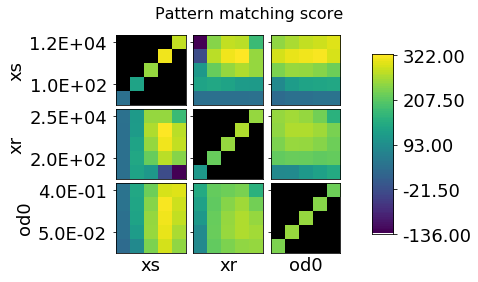

In [108]:
if noxs_flag:
    fit_df = pd.read_csv('fit_df_noxs.csv', index_col=0)
else:
    fit_df = pd.read_csv('pool_params/score_df.csv', index_col=0)

def make_plot(ax, x_var, y_var, c_var, var_list, fit_df):
    if x_var == y_var:
        ind = np.prod(
            [np.isclose(fit_df.loc[:,xx], def_parms[xx]) for xx in var_list if xx not in [x_var, c_var]],
            axis=0)>0
        if np.all(ind):
            ind = fit_df.index
        sub_df = fit_df.loc[ind, [x_var, c_var]]
        piv_df = sub_df.groupby(x_var, as_index=True).mean()
        t_inds = np.arange(1,n_powers,3)
        y_vec = piv_df.index.values
        n = len(y_vec)
        arr = np.empty((n,n)) * np.nan
        for i in np.arange(n):
            arr[i,i] = piv_df.values[i]
        y_labs = ["{:.1E}".format(xx) for xx in y_vec[t_inds]]
        c_all = fit_df.loc[:,c_var]
        vmin, vmax = np.array([f(c_all) for f in [np.min, np.max]], dtype=np.float)
        ax.imshow(arr, vmin=vmin, vmax=vmax, origin='lower')
        ax.set_yticks(t_inds)
        ax.set_yticklabels(y_labs)
#         ax.set_xticks(t_inds)
        ax.set_xticks([])
        ax.set_xticklabels(y_labs, rotation=-45)
        ax.set_aspect(1)
        ax.set_facecolor('black')
    else:
        ind = np.prod(
            [np.isclose(fit_df.loc[:,xx], def_parms[xx]) for xx in var_list if xx not in [x_var, y_var, c_var]],
            axis=0)>0
        if np.all(ind):
            ind = fit_df.index
        sub_df = fit_df.loc[ind, [x_var, y_var, c_var]]
        piv_df = sub_df.groupby([x_var, y_var], as_index=False).mean().pivot(y_var, x_var, c_var)
        t_inds = np.arange(1,n_powers,3)
        x_vec = piv_df.columns.values
        y_vec = piv_df.index.values
        x_labs = ["{:.1E}".format(xx) for xx in x_vec[t_inds]]
        y_labs = ["{:.1E}".format(xx) for xx in y_vec[t_inds]]
        c_all = fit_df.loc[:,c_var]
        vmin, vmax = np.array([f(c_all) for f in [np.min, np.max]], dtype=np.float)
        ax.imshow(piv_df.values, vmin=vmin, vmax=vmax, origin='lower')
#         ax.set_xticks(t_inds)
        ax.set_xticks([])
        ax.set_xticklabels(x_labs, rotation=-45)
        ax.set_yticks(t_inds)
        ax.set_yticklabels(y_labs)
        ax.set_aspect(1)

def make_cbar(ax, c_var, fit_df):
    c_vec = fit_df.loc[:,c_var]
    c_ext = np.array([f(c_vec) for f in [np.min, np.max]], dtype=np.float)
    if len(np.unique(c_vec.values)) == 2:
        n_colors = 2
        n_ticks = 2
        bar_width = 2
    else:
        n_colors = 100
        n_ticks = 5
        bar_width = n_colors//8
    int_x = np.linspace(c_ext[0],c_ext[1],n_ticks)
    im_vec = np.linspace(1,1/255,n_colors)
    im_arr = np.tile(im_vec, (bar_width,1)).T
    ax.imshow(im_arr, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks(np.linspace(1/255, n_colors, n_ticks))
    ax.set_yticklabels(["{:0.2f}".format(xx) for xx in int_x[::-1]])
    ax.yaxis.tick_right()

def make_grid_fig(vl_tmp, cvar, df_tmp):
    gs = mpl.gridspec.GridSpec(n_var*ax_width, n_var*ax_width+2)#, width_ratios=[1]*n_var + [0.1])
    for i, vy in enumerate(vl_tmp):
        for j, vx in enumerate(vl_tmp):
    #         ax = plt.subplot2grid((n_var, n_var+1),(i,j))
            ax = plt.subplot(gs[i*ax_width:i*ax_width+ax_width,j*ax_width:j*ax_width+ax_width])
            make_plot(ax, vx, vy, cvar, vl_tmp, df_tmp)
            if i == n_var-1:
                ax.set_xlabel(vx)
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(vy)
            else:
                ax.set_yticklabels([])

    # ax = plt.subplot2grid((n_var, n_var+1),(0,j+1), rowspan=n_var)
    ax = plt.subplot(gs[:,-1])
    make_cbar(ax, cvar, df_tmp)

vl_tmp = ['xs', 'xr', 'od0'] #var_list
ind = np.prod(
    [np.isclose(fit_df.loc[:,xx], def_parms[xx] ) for xx in var_list if xx not in vl_tmp],
#     [np.isclose(fit_df.loc[:,xx], fit_df.loc[1341, xx] ) for xx in var_list if xx not in vl_tmp],
    axis=0)>0
if ind.size < 2:
    ind = fit_df.index
n_var = len(vl_tmp)
ax_width = 3
cvar = 'score'
# cols = vl_tmp + pulse_features#par_list + ['reach', 'pulse', 'mean_v', 'amp', 'width'] 
df_tmp = fit_df.loc[ind,cols].copy().dropna(how='any', axis=0)
# df_tmp = df_tmp.loc[df_tmp.loc[:,'xs']>0,:]
# df_tmp = df_tmp.loc[fit_df.amp>0,:]
# df_tmp.loc[df_tmp.amp>0,"amp"] = np.log10(df_tmp.loc[df_tmp.amp>0,"amp"])
fig_size = (5,4)
fig = plt.figure(figsize=fig_size)
make_grid_fig(vl_tmp, cvar, df_tmp)
plt.suptitle('Pattern matching score', fontsize=16)
fig.savefig("score_grid.pdf")
    
    
# cvar = 'score'
# # cols = vl_tmp + pulse_features#par_list + ['reach', 'pulse', 'mean_v', 'amp', 'width'] 
# df_tmp = fit_df.loc[ind,cols].copy().dropna(how='any', axis=0)
# # df_tmp = df_tmp.loc[df_tmp.loc[:,'xs']>0,:]
# # df_tmp = df_tmp.loc[fit_df.amp>0,:]
# # df_tmp.loc[df_tmp.amp>0,"amp"] = np.log10(df_tmp.loc[df_tmp.amp>0,"amp"])
# fig_size = (10,8)
# fig = plt.figure(figsize=fig_size)
# make_grid_fig(vl_tmp, cvar, df_tmp)
# plt.suptitle('Pattern matching score', fontsize=16)
# if noxs_flag:
#     fig.savefig("mean_vel_plot_all_noxs.pdf")
# else:
#     fig.savefig("mean_vel_plot_mscarlet.pdf")


In [19]:
# p0 = np.array([dx,Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,od0])

# Params :    ,           dx               Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
p0 = np.array([np.power((scale/4.5),2),   0,    8e-3,  8e-3, 15,  3e-2,  1, 3e-2, 8e-2, 5e2, 2e2, 
#xr,   hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   od0
1e3, 3.2, 100, 2.3, 55, 3.2, 2.7e3, 16e-3, 3e3, 0.01], dtype=np.float32)
indx_str = 2331
p0 = score_df.loc[indx_str,'dx':].values
score = score_df.loc[indx_str,'score']
img, tvec = sim(n_h, n_w, p0)

anim = write_movie(img, tvec, skip=4, score=score, indx=indx_str)
HTML(anim.to_html5_video())

NameError: name 'score_df' is not defined

In [15]:
writer = anm.ImageMagickWriter(fps=20)
anim.save("2331_sparese.gif", writer=writer)

In [61]:
indx_list = []
all_indx_list = score_df_sorted.index.values
for score_lim in [-100, 0, 100, 200, 300, 400]:
    add_score = all_indx_list[score_df_sorted.score <= score_lim][0]
    indx_list.append(add_score)


In [62]:
writer = anm.ImageMagickWriter(fps=20)
for indx_str in indx_list:
    p0 = score_df.loc[indx_str,'dx':].values
    score = score_df.loc[indx_str,'score']
    img, tvec = sim(n_h, n_w, p0)
    anim = write_movie(img, tvec, skip=4, score=score, indx=indx_str)
    anim.save("gifs/" + indx_str + ".gif", writer=writer)

Starting
(93600,)
(93600,)


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in greater


0
DONE
Starting
(93600,)
(93600,)


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in greater


0
DONE
Starting
(93600,)
(93600,)


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in greater


0
DONE
Starting
(93600,)
(93600,)
0
DONE
Starting
(93600,)
(93600,)


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in greater


0
DONE
Starting
(93600,)
(93600,)


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in greater


0
DONE


In [66]:
def get_mask(im_movie):
    final_syn = im_movie[:,syn_inds,:,:].max(axis=0).sum(axis=0)
    if np.all(final_syn == final_syn[0,0]):
        return 0
    thresh = skimage.filters.threshold_otsu(final_syn)
    thresh_syn = final_syn > thresh
    arr = np.zeros((species, n_h, n_w))
    dest_wells, ahl_centers = prep_spot_positions(n_h, n_w)
    dims = np.array([species, n_h, n_w])
    arr = prep_initial_condition(dest_wells, ahl_centers, dims, p0, arr)
    mask = arr[cell_inds,:,:].sum(axis=0) > 0
    im_label = skimage.morphology.label(mask)
    im_ac_mask = np.zeros(im_label.shape)
    im_ac_pnlt = np.zeros(im_label.shape)
    for i in np.arange(1,np.max(im_label)+1):
        if i in [1, 2, 4, 5, 9, 10, 12, 14, 16, 17, 25]:
            im_ac_mask += im_label == i
        else:
            im_ac_pnlt += im_label == i
    score = np.sum(thresh_syn * im_ac_mask) - np.sum(thresh_syn * im_ac_pnlt)
    return im_ac_mask - im_ac_pnlt

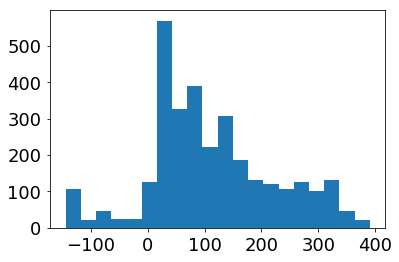

In [106]:
tmp = score_df.score.values
_ = plt.hist(tmp.astype(np.float), bins=20)

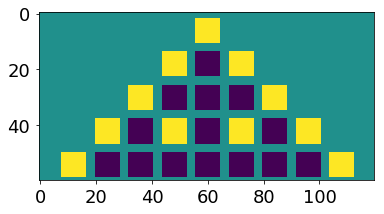

In [95]:
plt.imshow(mask)

In [8]:
score_df = pd.read_csv('pool_params/score_df.csv', index_col=0)

In [10]:
score_df.loc[score_df.score == score_df.score.max(),:]

,score,scale,n_h,n_w,dx,Dc,rc,rp,Kn,Dn,...,xr,hS,kS,hR,kR,hC,kC,pa,leak,od0
2201,391.0,12.0,60.0,120.0,7.111111,0.0,0.008,0.008,15.0,0.03,...,1000.0,3.2,100.0,2.3,55.0,3.2,108.0,0.016,6000.0,0.2
2461,391.0,12.0,60.0,120.0,7.111111,0.0,0.008,0.008,15.0,0.03,...,25000.0,3.2,100.0,2.3,55.0,3.2,2700.0,0.016,6000.0,0.2
2331,391.0,12.0,60.0,120.0,7.111111,0.0,0.008,0.008,15.0,0.03,...,5000.0,3.2,100.0,2.3,55.0,3.2,540.0,0.016,6000.0,0.2
